<a href="https://colab.research.google.com/github/Mahesh7667/Knowing-Your-Customers-A-Data-Driven-Approach/blob/main/Knowing_Your_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow pandas numpy matplotlib scikit-learn


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns




In [4]:
# Load the dataset
#file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/online_retail_II.xlsx'  # Update with your file path
#df = pd.read_excel(file_path, engine='openpyxl')

!curl -o online_retail_II.zip "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
!unzip online_retail_II.zip
!rm online_retail_II.zip
df = pd.read_excel("online_retail_II.xlsx", engine='openpyxl')

#df.to_csv('csvfile.csv', encoding='utf-8', index=False)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.5M    0 43.5M    0     0  29.4M      0 --:--:--  0:00:01 --:--:-- 29.4M
Archive:  online_retail_II.zip
 extracting: online_retail_II.xlsx   


In [5]:
# Display the first few rows
print(df.head())

# Display dataset information
print(df.info())

# Display summary statistics
print(df.describe())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invo

In [6]:
# Drop rows with missing CustomerID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove rows with non-positive Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


In [7]:
# Calculate TotalSales
df['TotalSales'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


<ipython-input-7-242bdb561d31>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSales'] = df['Quantity'] * df['Price']
<ipython-input-7-242bdb561d31>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [8]:
# Set reference date (e.g., one day after the last transaction date)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalSales': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [9]:
# Define scoring criteria for each RFM value
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
rfm['RecencyScore'] = pd.cut(rfm['Recency'], bins=5, labels=recency_scores)
rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=5, labels=frequency_scores)
rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=5, labels=monetary_scores)

# Convert RFM scores to numeric type
rfm['RecencyScore'] = rfm['RecencyScore'].astype(int)
rfm['FrequencyScore'] = rfm['FrequencyScore'].astype(int)
rfm['MonetaryScore'] = rfm['MonetaryScore'].astype(int)


In [10]:
# Define RFM score function
def rfm_score(x, quantiles):
    if x <= quantiles[0.25]:
        return 1
    elif x <= quantiles[0.50]:
        return 2
    elif x <= quantiles[0.75]:
        return 3
    else:
        return 4

# Calculate quantiles
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])

# Apply RFM score
rfm['R_Score'] = rfm['Recency'].apply(rfm_score, args=(quantiles['Recency'],))
rfm['F_Score'] = rfm['Frequency'].apply(rfm_score, args=(quantiles['Frequency'],))
rfm['M_Score'] = rfm['Monetary'].apply(rfm_score, args=(quantiles['Monetary'],))

# Combine RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [11]:
# Define segments
def segment_customer(df):
    if df['RFM_Score'] == '444':
        return 'Best Customers'
    elif df['R_Score'] == 4:
        return 'Loyal Customers'
    elif df['F_Score'] == 4:
        return 'Frequent Buyers'
    elif df['M_Score'] == 4:
        return 'Big Spenders'
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


<ipython-input-12-9a0d690191f0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


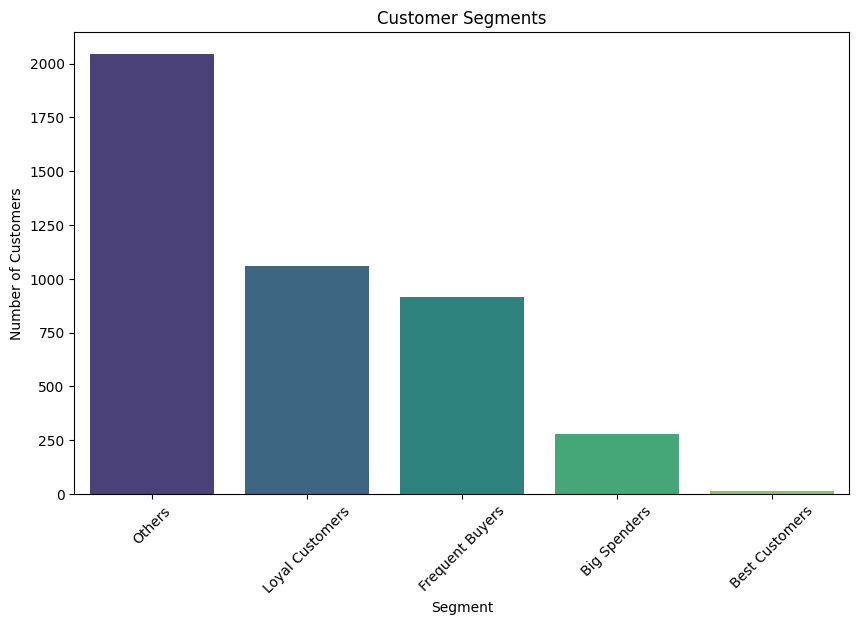

In [12]:
# Count of customers in each segment
segment_counts = rfm['Segment'].value_counts()

# Plot segment counts
plt.figure(figsize=(10,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [13]:
# Calculate RFM score by combining the individual scores
rfm['RFM_Score'] = rfm['RecencyScore'] + rfm['FrequencyScore'] + rfm['MonetaryScore']

# Define segments based on RFM score
def segment_customer(df):
    if df['RFM_Score'] >= 9:
        return 'Champions'
    elif df['RFM_Score'] >= 6:
        return 'Potential Loyalists'
    elif df['RFM_Score'] >= 5:
        return 'At Risk Customers'
    else:
        return 'Lost'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


<ipython-input-14-9a0d690191f0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


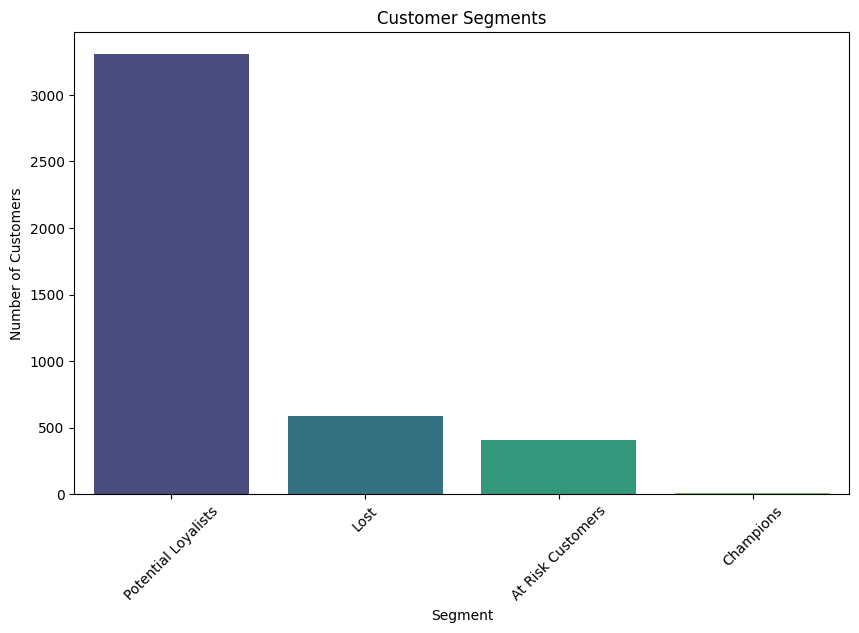

In [14]:
# Count of customers in each segment
segment_counts = rfm['Segment'].value_counts()

# Plot segment counts
plt.figure(figsize=(10,6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
# Set reference date (e.g., one day after the last transaction date)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalSales': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [17]:
# Log transformation
rfm_log = np.log1p(rfm)

# Standardization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)


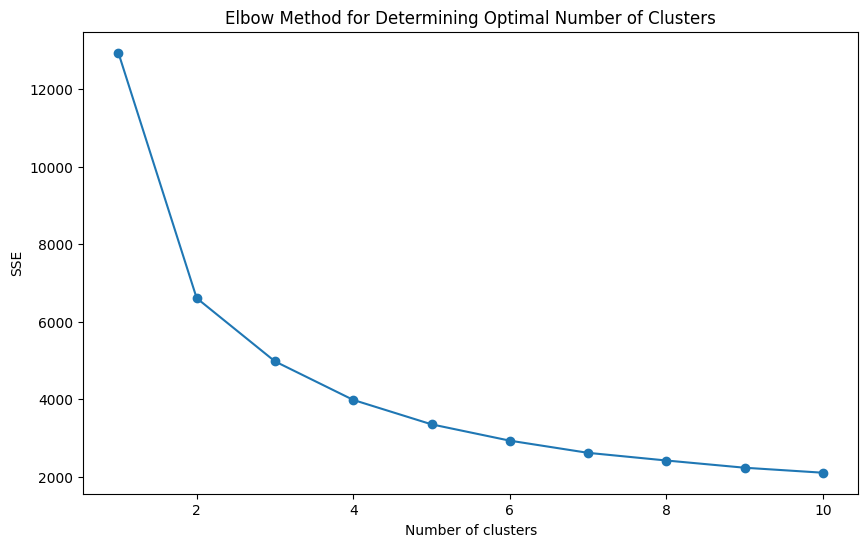

In [18]:
# Elbow method to determine optimal number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Determining Optimal Number of Clusters")
plt.show()


In [19]:
# Apply K-Means with the optimal number of clusters
optimal_clusters = 4  # Update based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


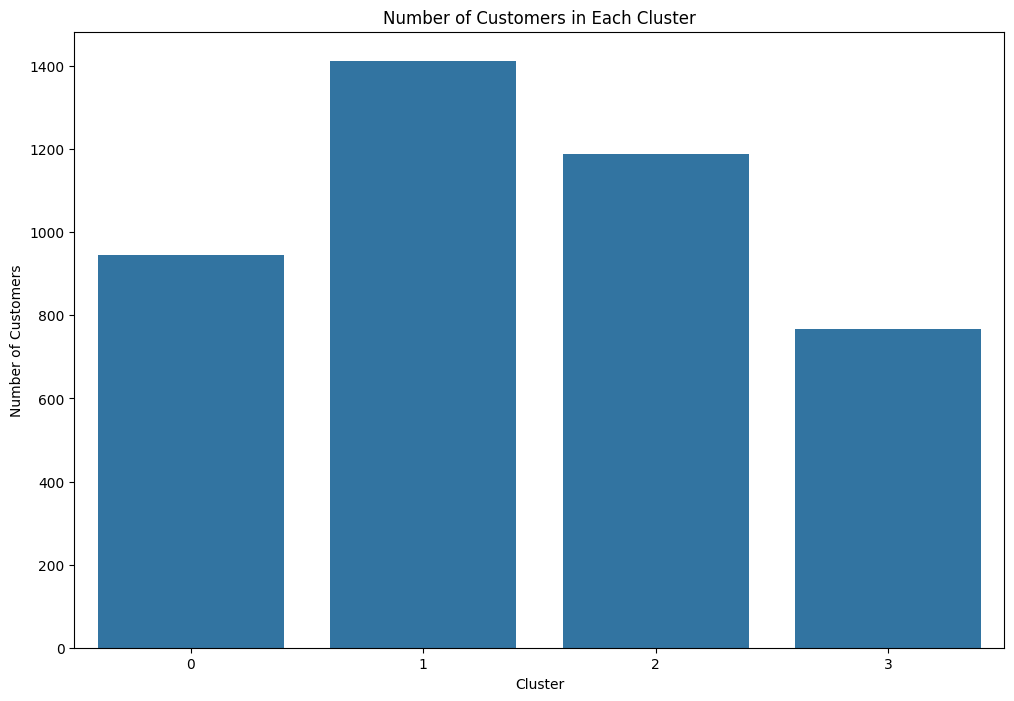

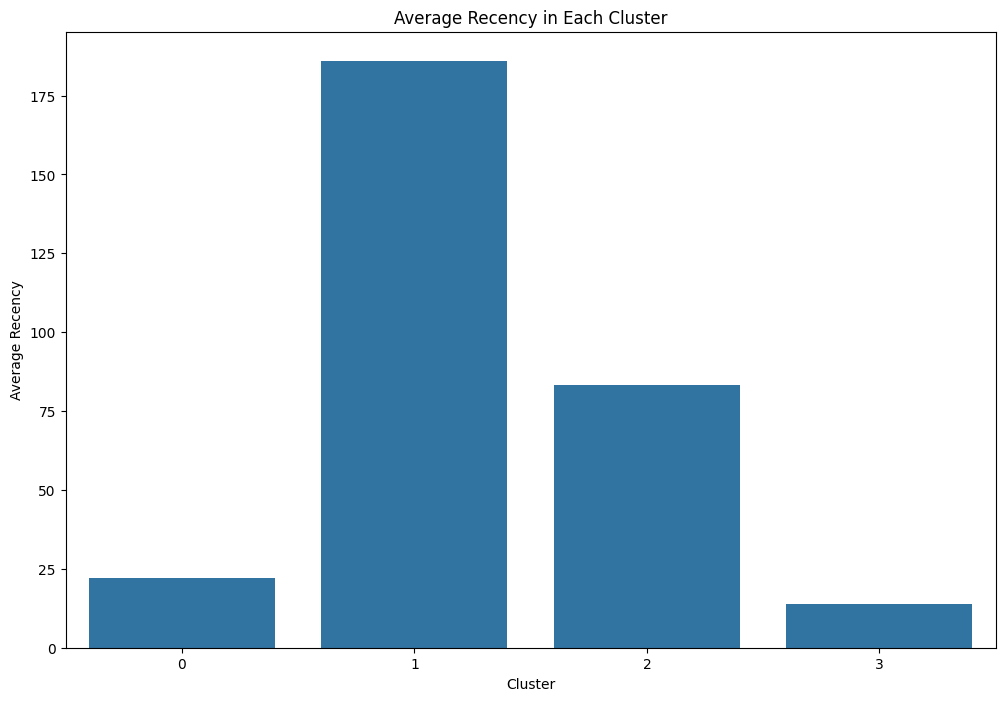

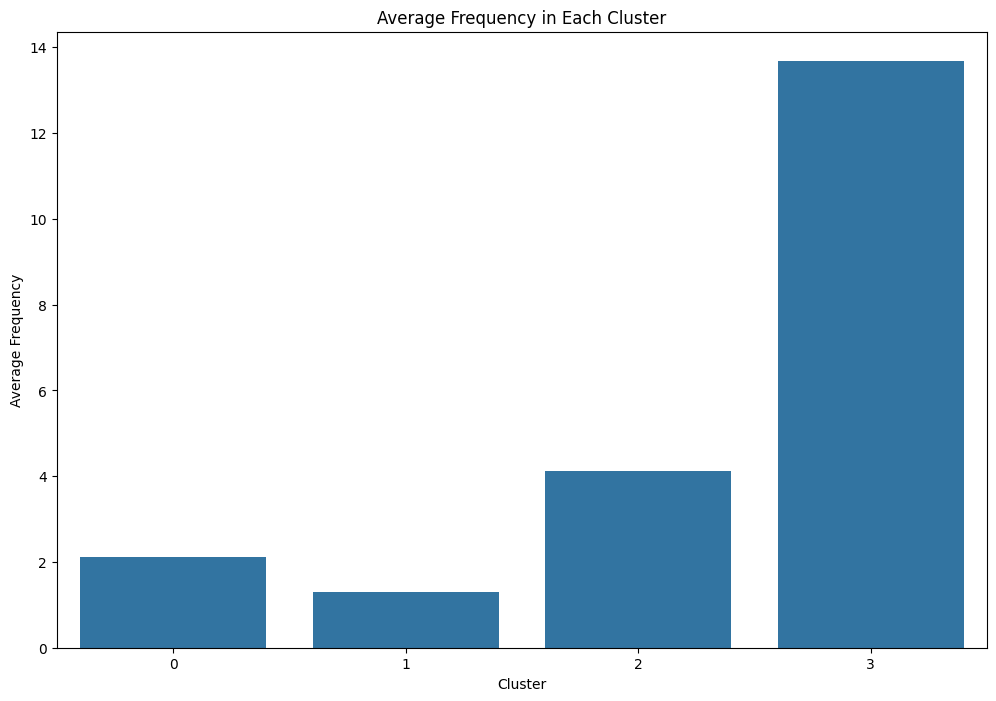

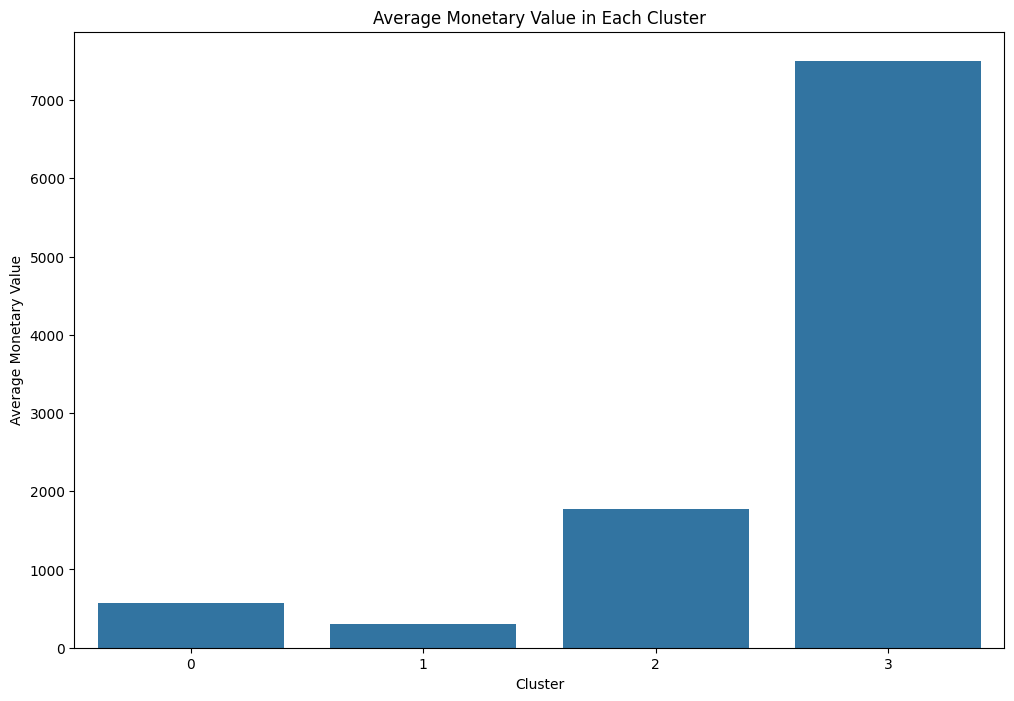

In [20]:
# Add cluster labels to the original RFM data
rfm['Cluster'] = kmeans.labels_

# Calculate average RFM values and size for each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'}).reset_index()

# Plot the cluster summary
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Count', data=cluster_summary)
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Plot RFM values for each cluster
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Recency', data=cluster_summary)
plt.title('Average Recency in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Frequency', data=cluster_summary)
plt.title('Average Frequency in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='Monetary', data=cluster_summary)
plt.title('Average Monetary Value in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Monetary Value')
plt.show()


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



<ipython-input-22-e88fa7a3f095>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0], palette="Set2")
<ipython-input-22-e88fa7a3f095>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1], palette="Set2")
<ipython-input-22-e88fa7a3f095>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2], palette="Set2")


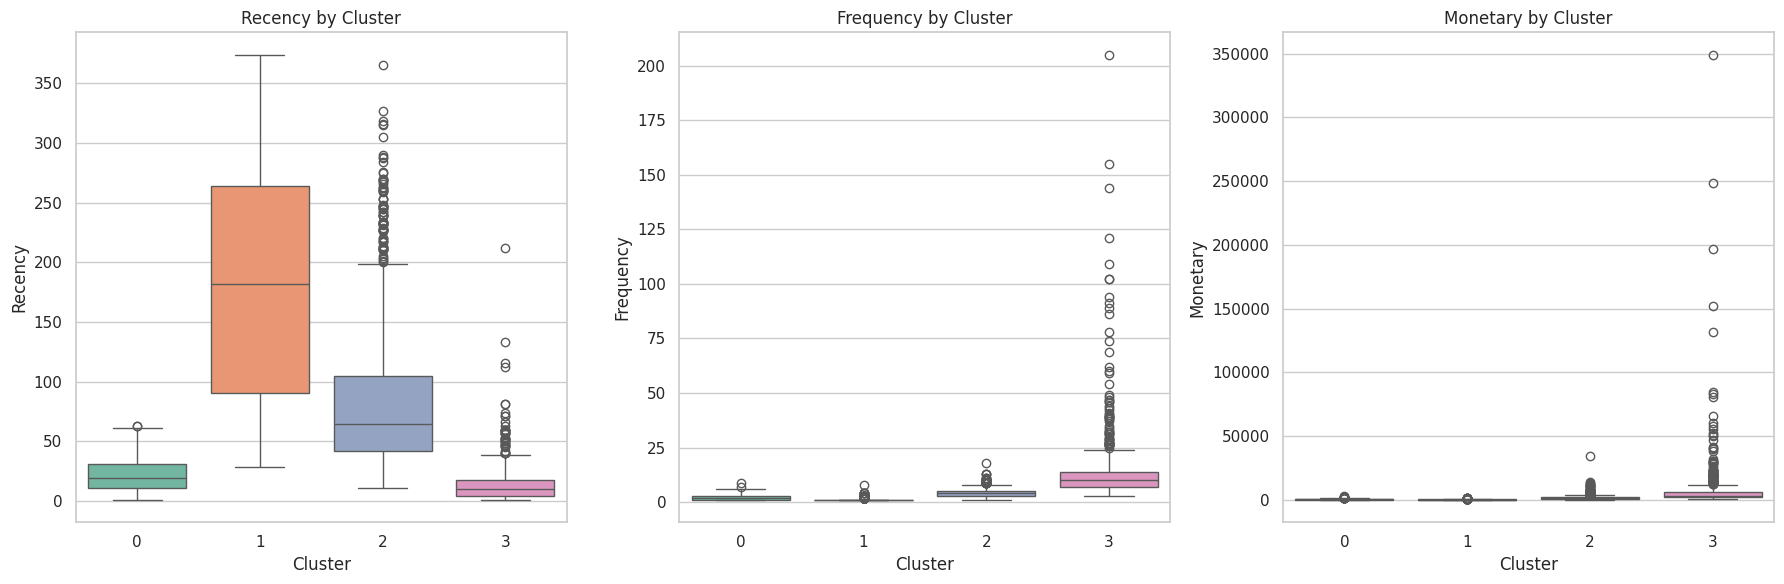

In [22]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Recency
sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0], palette="Set2")
axes[0].set_title('Recency by Cluster')

# Plot Frequency
sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1], palette="Set2")
axes[1].set_title('Frequency by Cluster')

# Plot Monetary
sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2], palette="Set2")
axes[2].set_title('Monetary by Cluster')

# Display the plots
plt.tight_layout()
plt.show()



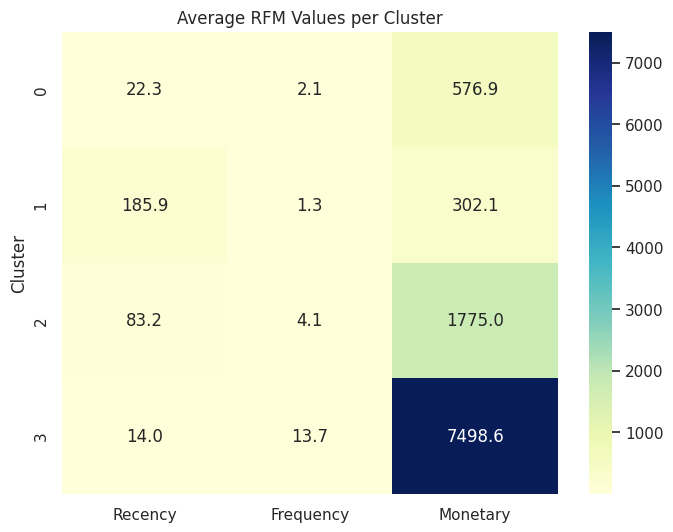

In [23]:
# Calculate the average RFM values for each cluster
cluster_avg = rfm.groupby('Cluster').mean().round(1)

# Reset index for better readability
cluster_avg = cluster_avg.reset_index()

# Set 'Cluster' as index
cluster_avg = cluster_avg.set_index('Cluster')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_avg, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Average RFM Values per Cluster')
plt.show()


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
!pip install google-cloud-bigquery pandas matplotlib seaborn


In [26]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

# Set your Google Cloud project ID
project_id = "retail-449009"



In [27]:
client = bigquery.Client(project=project_id)


In [28]:
query = """
SELECT *
FROM `retail-449009.retailsales.customer_clusters`
"""
df = client.query(query).to_dataframe()

# Display the DataFrame
print(df.head())


   Customer ID  Recency  Frequency  Monetary  Cluster
0      17180.0     5376          1     43.70        3
1      14854.0     5376          1     93.16        3
2      13979.0     5376          1     11.25        3
3      16108.0     5376          1      2.50        3
4      17092.0     5376          1    132.82        3


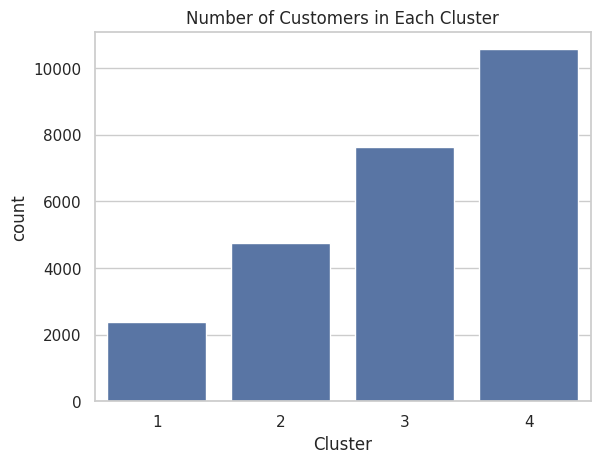

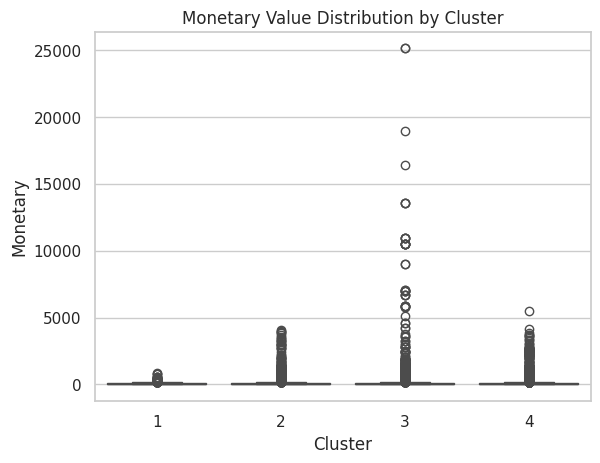

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart: Number of customers in each cluster
sns.countplot(x='Cluster', data=df)
plt.title('Number of Customers in Each Cluster')
plt.show()

# Box plot: Monetary value distribution by cluster
sns.boxplot(x='Cluster', y='Monetary', data=df)
plt.title('Monetary Value Distribution by Cluster')
plt.show()


In [30]:
cluster_summary = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).rename(columns={'customer_id': 'num_customers'})
print(cluster_summary)


             Recency  Frequency    Monetary  Customer ID
Cluster                                                 
1        5524.443049        1.0   53.461018         2219
2         5452.69234   1.003165   96.131205         4417
3        5351.026588   1.025278  145.619366         6929
4        5218.720534   1.004828   85.706440         9922


In [31]:
# Example: Add business labels to clusters
cluster_labels = {
    1: 'High Value',
    2: 'At Risk',
    3: 'Low Value',
    4: 'Loyal Customers'
}
df['Cluster Label'] = df['Cluster'].map(cluster_labels)


In [32]:
X = rfm[['Recency', 'Frequency', 'Monetary']]  # Features
y = rfm['Cluster']  # Target

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       189
           1       0.99      0.98      0.99       277
           2       0.97      0.96      0.96       243
           3       0.96      0.95      0.96       154

    accuracy                           0.97       863
   macro avg       0.97      0.97      0.97       863
weighted avg       0.97      0.97      0.97       863

Confusion Matrix:
 [[186   0   0   3]
 [  3 271   3   0]
 [  4   2 234   3]
 [  2   0   5 147]]


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build a neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(rfm['Cluster'].unique()), activation='softmax')  # One output for each cluster
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5607 - loss: 1.1459 - val_accuracy: 0.7404 - val_loss: 0.6513
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7747 - loss: 0.5702 - val_accuracy: 0.8644 - val_loss: 0.3917
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8620 - loss: 0.3689 - val_accuracy: 0.8888 - val_loss: 0.2861
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9043 - loss: 0.2687 - val_accuracy: 0.9085 - val_loss: 0.2450
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9082 - loss: 0.2431 - val_accuracy: 0.9166 - val_loss: 0.2187
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9205 - loss: 0.2049 - val_accuracy: 0.9119 - val_loss: 0.1983
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9294 - loss: 0.1777 - val_accuracy: 0.9293 - val_loss: 0.1781
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9353 - loss: 0.1775 - val_accur

In [35]:
# Example new customer data
new_customers = pd.DataFrame({
    'Recency': [10, 50],
    'Frequency': [5, 2],
    'Monetary': [300, 50]
})

# Scale the new data
new_customers_scaled = scaler.transform(new_customers)

# Predict clusters
predicted_clusters = rf_model.predict(new_customers_scaled)
print("Predicted Clusters:", predicted_clusters)


Predicted Clusters: [0 1]


In [36]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Num_Customers'})

print(cluster_summary)


            Recency  Frequency     Monetary  Num_Customers
Cluster                                                   
0         22.250794   2.121693   576.945207            945
1        185.938385   1.288244   302.142020           1412
2         83.191919   4.122054  1775.009363           1188
3         13.988266  13.679270  7498.636764            767


In [37]:
cluster_labels = {
    0: 'Loyal Customers',
    1: 'At-Risk Customers',
    2: 'Low-Value Customers',
    3: 'High-Value Customers'
}

# Add business labels to the DataFrame
rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)
print(rfm[['Cluster', 'Cluster_Label']].head())


             Cluster        Cluster_Label
Customer ID                              
12346.0            2  Low-Value Customers
12347.0            0      Loyal Customers
12348.0            1    At-Risk Customers
12349.0            2  Low-Value Customers
12351.0            0      Loyal Customers


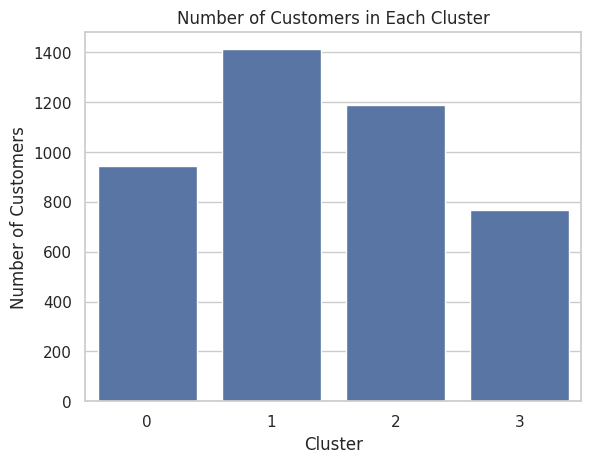

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Cluster', data=rfm)
plt.title('Number of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


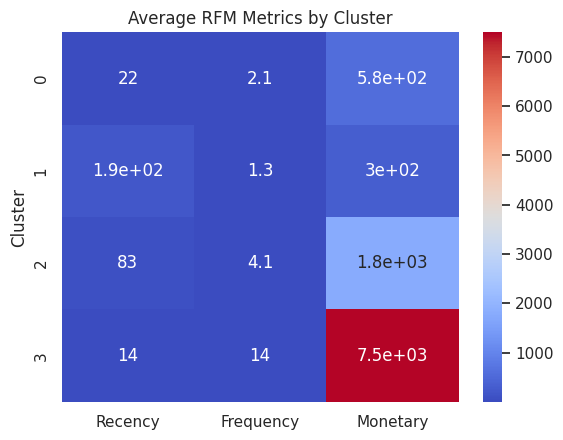

In [39]:
sns.heatmap(cluster_summary.drop(columns='Num_Customers'), annot=True, cmap='coolwarm')
plt.title('Average RFM Metrics by Cluster')
plt.show()


In [40]:
import plotly.express as px

fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
                     color='Cluster', opacity=0.8, size_max=10)
fig.update_layout(title="3D Customer Segmentation Scatter Plot")
fig.show()


In [41]:
import pandas as pd
import plotly.express as px

# Define customer segments based on cluster labels
segment_map = {
    0: "Occasional Buyers",
    1: "At-Risk Customers",
    2: "Loyal Customers",
    3: "High-Value Customers"
}

# Apply mapping and handle NaNs
df['Segment'] = df['Cluster'].map(segment_map)
df['Segment'] = df['Segment'].fillna("Unknown")  # Fix missing values

# Ensure monetary values are valid (remove negative values if necessary)
df['Monetary'] = df['Monetary'].abs()

# Generate Sunburst Chart
fig = px.sunburst(df, path=['Segment', 'Cluster'], values='Monetary',
                  color='Cluster', hover_data=['Recency', 'Frequency'])

fig.update_layout(title="Customer Segmentation - Sunburst Chart")
fig.show()


/usr/local/lib/python3.11/dist-packages/plotly/express/_core.py:1745: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



📜 Python Code for CLV Estimation
python
Copy
Edit


In [42]:

!pip install lifetimes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00


In [43]:
!pip install lifetimes

In [44]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter
df = pd.read_excel("online_retail_II.xlsx", engine='openpyxl')

# Compute 'T' (Customer's Age in dataset)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm_data = df.groupby('Customer ID').agg({
    'InvoiceDate': [lambda x: (reference_date - x.max()).days,  # Recency
                    lambda x: (reference_date - x.min()).days],  # T (Customer's Age in dataset)
    'Invoice': 'count',  # Frequency
    'Price': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm_data.columns = ['Customer ID', 'Recency', 'T', 'Frequency', 'Monetary']

# Remove invalid cases where Recency > T
rfm_data = rfm_data[rfm_data["Recency"] <= rfm_data["T"]]

# Ensure Frequency > 0
rfm_data = rfm_data[rfm_data["Frequency"] > 1]  # Remove first-time buyers


      Customer ID           CLV
9         12357.0  1.140926e+06
3043      16501.0  7.102789e+05
4207      18043.0  5.680399e+05
2568      15880.0  4.885722e+05
2088      15211.0  3.294291e+05
463       13030.0  2.992081e+05
1859      14899.0  2.920899e+05
1459      14382.0  2.879726e+05
3619      17269.0  2.854814e+05
2529      15828.0  2.539683e+05


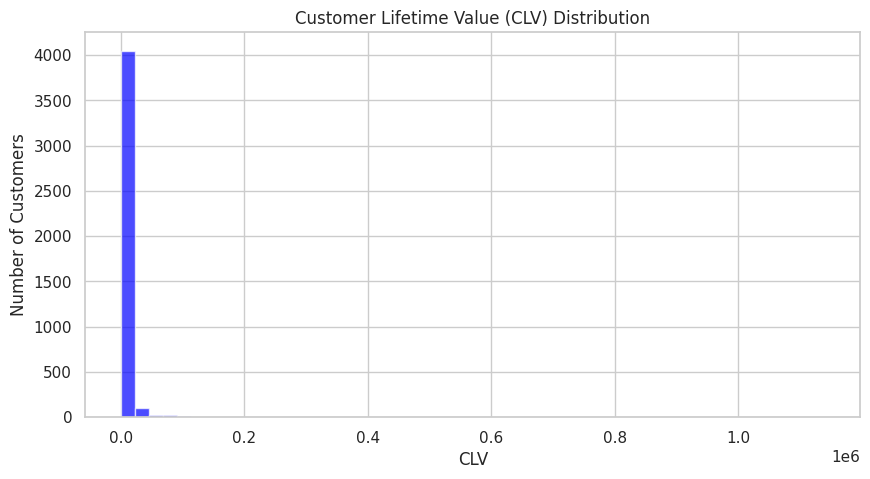

In [45]:

# Fit the BG/NBD model for purchase predictions
# Increase the penalizer coefficient to help convergence
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Default is 0.001, try increasing to 0.01 or higher
bgf.fit(rfm_data["Frequency"], rfm_data["Recency"], rfm_data["T"])


# Predict purchases in next 6 months
rfm_data["Predicted_Purchases"] = bgf.predict(180, rfm_data["Frequency"], rfm_data["Recency"], rfm_data["T"])

# Fit Gamma-Gamma model for revenue predictions
ggf = GammaGammaFitter()
ggf.fit(rfm_data["Frequency"], rfm_data["Monetary"])

# Predict monetary value
rfm_data["Predicted_Monetary"] = ggf.conditional_expected_average_profit(rfm_data["Frequency"], rfm_data["Monetary"])

# Calculate CLV (Customer Lifetime Value) with a discount rate of 5%
rfm_data["CLV"] = rfm_data["Predicted_Purchases"] * rfm_data["Predicted_Monetary"] * 0.95

# Display Top 10 Customers by CLV
print(rfm_data[['Customer ID', 'CLV']].sort_values(by="CLV", ascending=False).head(10))

# Plot CLV Distribution
plt.figure(figsize=(10, 5))
plt.hist(rfm_data["CLV"], bins=50, color='blue', alpha=0.7)
plt.title("Customer Lifetime Value (CLV) Distribution")
plt.xlabel("CLV")
plt.ylabel("Number of Customers")
plt.show()


🔹 2️⃣ Customer Journey Mapping


 Why is the Output Like This?
Highly Skewed Data: Most CLV values are concentrated near zero, while a few customers have very high CLV values, pushing the x-axis scale too wide.
Outliers: A few extreme CLV values (e.g., customers with very high spending) make most values appear bunched up on the left.
Logarithmic Scale Not Used: The raw CLV values span a large range (possibly thousands to millions), which makes the lower range visually compressed.
Poor Bin Selection: If the histogram bins are too wide, most values will fall into one or two bins near zero.

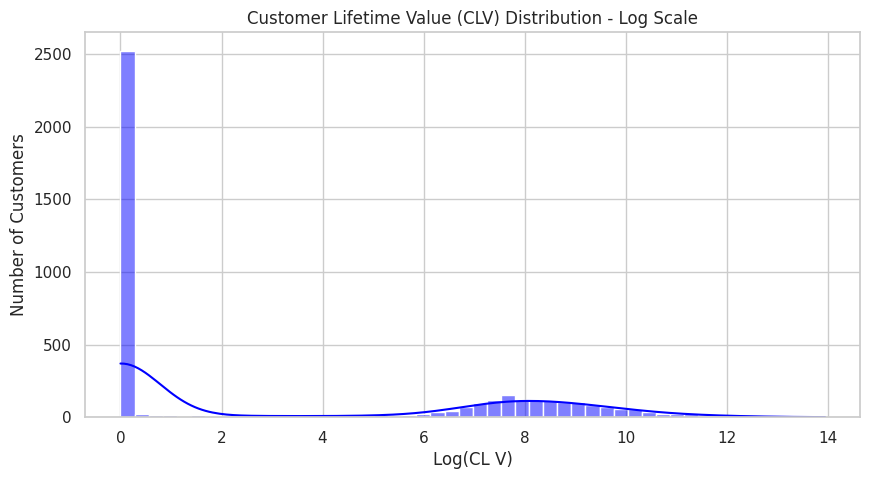

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Avoid zero values before log transformation
df['CLV_Log'] = np.log1p(rfm_data['CLV'])  # log(1 + CLV) to prevent log(0) errors

# Plot histogram with log-transformed values
plt.figure(figsize=(10, 5))
sns.histplot(df['CLV_Log'], bins=50, color='blue', kde=True)
plt.title('Customer Lifetime Value (CLV) Distribution - Log Scale')
plt.xlabel('Log(CL V)')
plt.ylabel('Number of Customers')
plt.show()


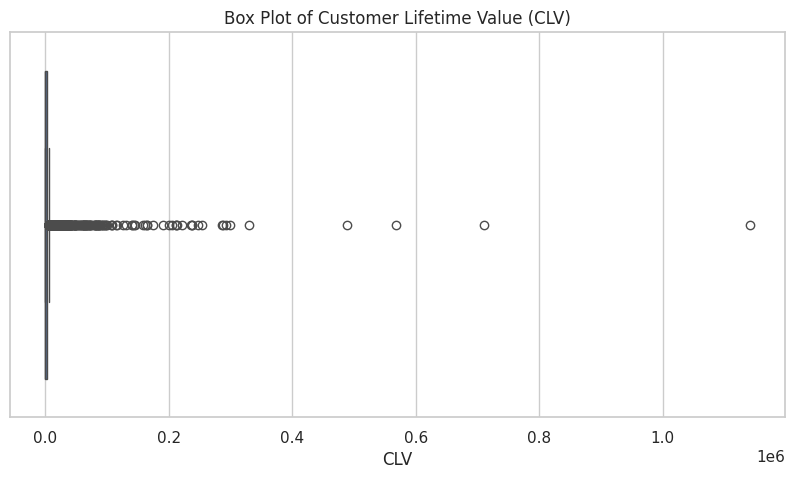

In [54]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=rfm_data['CLV'])
plt.title('Box Plot of Customer Lifetime Value (CLV)')
plt.show()


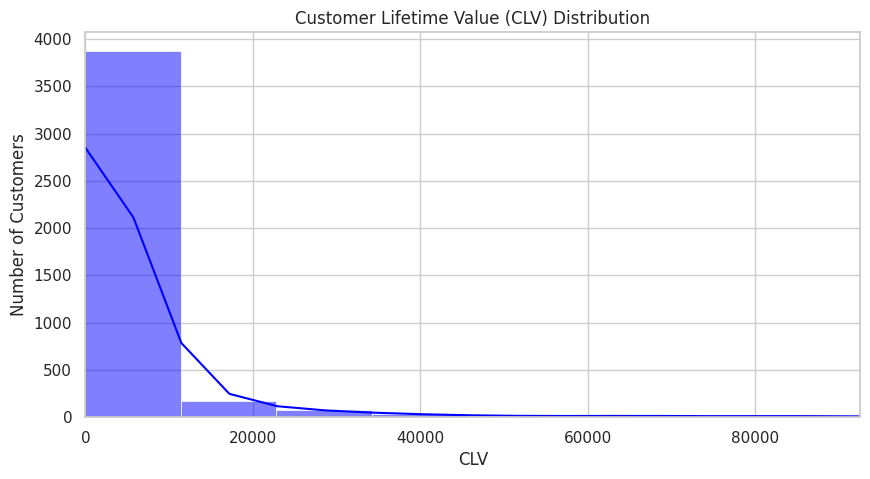

In [57]:
plt.figure(figsize=(10, 5))
sns.histplot(rfm_data['CLV'], bins=100, color='blue', kde=True)
plt.title('Customer Lifetime Value (CLV) Distribution')
plt.xlabel('CLV')
plt.ylabel('Number of Customers')
plt.xlim(0, np.percentile(rfm_data['CLV'], 99))  # Ignore extreme outliers
plt.show()


Your results indicate that the Customer Lifetime Value (CLV) distribution is highly skewed, with the majority of customers having low CLV, while a few customers have significantly high values. Here’s a summary of what the graphs reveal:

Interpretation of CLV Distribution Graphs
Histogram (First Image)

Most customers have a CLV close to zero.
Only a small number of customers contribute significantly to the overall revenue.
There is a long tail, indicating a few high-value customers.
Log Scale Distribution (Second Image)

Applying a logarithmic scale smooths the visualization, making the variation more interpretable.
It shows two distinct groups: low CLV customers and a smaller group with high CLV.
Box Plot (Third Image)

There are many outliers (extreme values) far from the median.
Most CLV values are clustered at the lower end, reinforcing the fact that a few customers contribute a disproportionate amount of revenue.

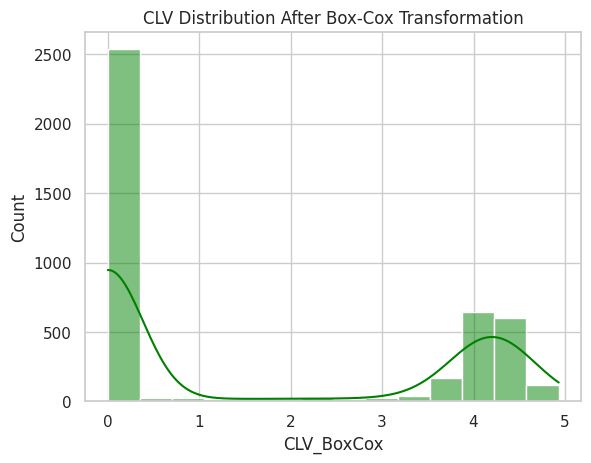

In [64]:
from scipy.stats import boxcox, yeojohnson

# Apply Box-Cox transformation (only works for positive values)
rfm_data['CLV_BoxCox'], lambda_val = boxcox(rfm_data['CLV'] + 1)  # Adding 1 to avoid zero values

# OR Apply Yeo-Johnson transformation (works for negative values too)
rfm_data['CLV_YeoJohnson'], lambda_yj = yeojohnson(rfm_data['CLV'])

# Plot the transformed data
sns.histplot(rfm_data['CLV_BoxCox'], kde=True, color='green')
plt.title('CLV Distribution After Box-Cox Transformation')
plt.show()


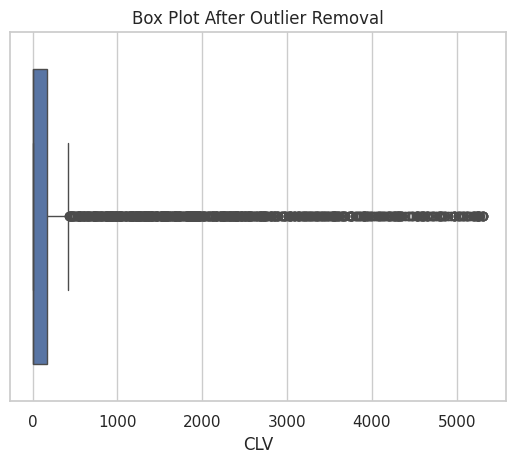

In [59]:
Q1 = rfm_data['CLV'].quantile(0.25)
Q3 = rfm_data['CLV'].quantile(0.75)
IQR = Q3 - Q1

# Define acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
rfm_data_no_outliers = rfm_data[(rfm_data['CLV'] >= lower_bound) & (rfm_data['CLV'] <= upper_bound)]

# Plot the filtered CLV
sns.boxplot(x=rfm_data_no_outliers['CLV'])
plt.title('Box Plot After Outlier Removal')
plt.show()


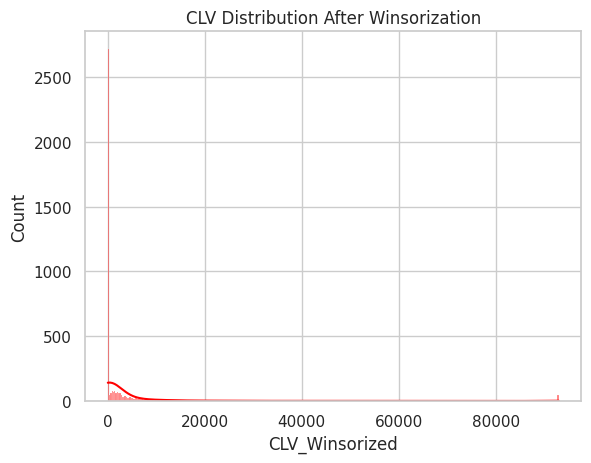

In [60]:
from scipy.stats.mstats import winsorize

# Winsorize top 1% of CLV values
rfm_data['CLV_Winsorized'] = winsorize(rfm_data['CLV'], limits=[0, 0.01])

# Plot CLV distribution after winsorization
sns.histplot(rfm_data['CLV_Winsorized'], kde=True, color='red')
plt.title('CLV Distribution After Winsorization')
plt.show()


In [61]:
# Define the threshold for high-value customers (95th percentile)
high_value_threshold = rfm_data['CLV'].quantile(0.95)

# Separate them
high_value_customers = rfm_data[rfm_data['CLV'] > high_value_threshold]
regular_customers = rfm_data[rfm_data['CLV'] <= high_value_threshold]

print("Number of High-Value Customers:", len(high_value_customers))
print("Number of Regular Customers:", len(regular_customers))


Number of High-Value Customers: 213
Number of Regular Customers: 4036


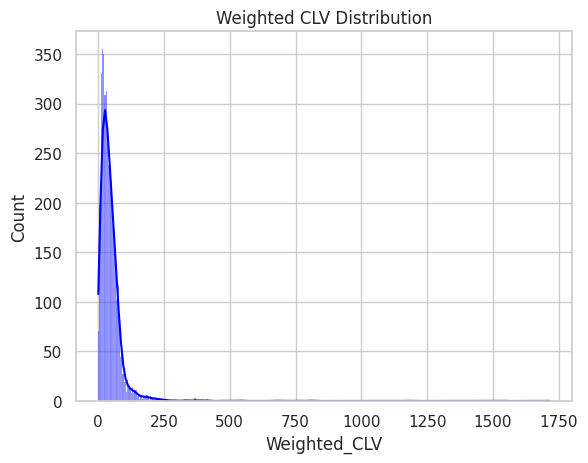

In [62]:
from sklearn.preprocessing import MinMaxScaler

# Scaling CLV to range [0,1] for better analysis
scaler = MinMaxScaler()
rfm_data['CLV_Scaled'] = scaler.fit_transform(rfm_data[['CLV']])

# Creating a weighted CLV metric
rfm_data['Weighted_CLV'] = (rfm_data['CLV_Scaled'] * 0.5) + (rfm_data['Frequency'] * 0.3) + (rfm_data['Recency'] * 0.2)

sns.histplot(rfm_data['Weighted_CLV'], kde=True, color='blue')
plt.title('Weighted CLV Distribution')
plt.show()


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features & Target
X = rfm_data[['Recency', 'Frequency', 'Monetary']]
y = rfm_data['CLV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error of CLV Predictions: {mae:.2f}")


Mean Absolute Error of CLV Predictions: 8676.82


In [50]:
print(df.columns)
print(rfm_data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Cluster'],
      dtype='object')
Index(['Customer ID', 'Recency', 'T', 'Frequency', 'Monetary',
       'Predicted_Purchases', 'Predicted_Monetary', 'CLV'],
      dtype='object')


In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Extract only relevant columns for RFM clustering
rfm_features = rfm_data[['Customer ID', 'Recency', 'Frequency', 'Monetary']].dropna()

# Remove duplicate Customer IDs (if any)
rfm_features = rfm_features.drop_duplicates(subset=['Customer ID'])

# Normalize Data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features[['Recency', 'Frequency', 'Monetary']])

# Apply K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_features['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Merge Cluster Labels back to the original dataframe
df = df.merge(rfm_features[['Customer ID', 'Cluster']], on='Customer ID', how='left')

# Verify the result
print(df[['Customer ID', 'Cluster']].head())


   Customer ID  Cluster
0      13085.0      0.0
1      13085.0      0.0
2      13085.0      0.0
3      13085.0      0.0
4      13085.0      0.0


In [ ]:
print(df.columns)  # Check main dataset
print(rfm_data.columns)  # Check RFM dataset


In [ ]:
df['CLV'] = df['CLV_x']  # If 'CLV_x' has the correct values
df.drop(columns=['CLV_x', 'CLV_y'], errors='ignore', inplace=True)  # Remove duplicate columns


In [ ]:
columns_to_drop = ['Predicted_Monetary', 'Predicted_Purchases']

# Drop duplicate columns if they exist in df
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

# Drop duplicate columns if they exist in rfm_data
rfm_data = rfm_data.drop(columns=[col for col in columns_to_drop if col in rfm_data.columns], errors='ignore')


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter

# Merge RFM data with df to include customer segmentation
df = df.merge(rfm_data, on='Customer ID', how='left')

# Ensure 'Month' is in Period format for correct grouping
df['Month'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')

# ✅ **Fix: Aggregate CLV per Customer per Month**
df_agg = df.groupby(['Customer ID', 'Month'])['CLV'].mean().reset_index()

# ✅ **Fix: Pivot without duplicate index issue**
customer_movements = df_agg.pivot(index="Customer ID", columns="Month", values="CLV").fillna("Unknown")

# Verify the new pivot table
print(customer_movements.head())

# ✅ **Count transitions between months**
transitions = {}
months = sorted(df_agg["Month"].unique())

for i in range(len(months) - 1):
    transition_counts = Counter(zip(customer_movements[months[i]], customer_movements[months[i+1]]))
    transitions[months[i]] = transition_counts

# Convert to DataFrame for visualization
transition_df = pd.DataFrame([(m, *t, c) for m, d in transitions.items() for t, c in d.items()],
                             columns=["Month", "From_CLV", "To_CLV", "Count"])

# ✅ **Sankey Diagram for Customer Journey**
fig = px.sankey(transition_df,
                node=dict(pad=15, thickness=20),
                link=dict(source=transition_df["From_CLV"],
                          target=transition_df["To_CLV"],
                          value=transition_df["Count"]),
                title="Customer Journey Flow Across CLV Segments")

fig.show()

# ✅ **Heatmap to Show Customer Transition Patterns**
plt.figure(figsize=(10, 6))
transition_matrix = pd.crosstab(df_agg["CLV"], df_agg["CLV"].shift(-1))
sns.heatmap(transition_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Customer CLV Transition Heatmap")
plt.xlabel("Next CLV Segment")
plt.ylabel("Previous CLV Segment")
plt.show()
